In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
final_time_data = pd.read_csv("covid_time_data.csv", header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
#final_time_data = final_time_data.rename(columns = {"Unnamed: 0": "Date"})
#final_time_data = final_time_data.set_index("Date")

In [87]:
final_time_data

,New_Cases,New_Deaths,Relative_Humidity,Average_Temperature,Average_Wind_Speed,Days_since_lockdown_lifted,Month,Day,Day_of_Week
2020-08-01,2212,48,21.675833,91.400000,3.932500,136,8,1,5
2020-08-02,1474,23,33.705000,85.100000,6.521667,137,8,2,6
2020-08-03,1621,9,43.670000,83.872727,7.429091,138,8,3,0
2020-08-04,1826,57,55.237500,77.750000,6.715000,139,8,4,1
2020-08-05,2298,67,62.220714,72.885714,3.780714,140,8,5,2
...,...,...,...,...,...,...,...,...,...
2021-03-28,520,23,15.703000,74.120000,2.876000,62,3,28,6
2021-03-29,358,0,17.336000,76.460000,7.713000,63,3,29,0
2021-03-30,375,9,45.266667,67.100000,4.697500,64,3,30,1
2021-03-31,605,33,10.657500,78.050000,8.919167,65,3,31,2


In [3]:
mean1 = final_time_data["New_Cases"].mean()
variance1 = final_time_data["New_Cases"].var()

mean2 = final_time_data["New_Deaths"].mean()
variance2 = final_time_data["New_Deaths"].var()

print(mean1)
print(variance1)
print(mean2)
print(variance2)

4225.264462809917
25117749.008607395
76.51652892561984
9160.018397860158


## Incidence 

In [96]:
mask = np.random.rand(len(final_time_data)) < 0.8
df_train = final_time_data[mask]
df_test = final_time_data[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=201
Testing data set length=41


In [97]:
expr = 'New_Cases ~ Relative_Humidity  + Average_Temperature + Average_Wind_Speed + Days_since_lockdown_lifted + Month + Day + Day_of_Week'
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              New_Cases   No. Observations:                  201
Model:                            GLM   Df Residuals:                      193
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6648e+05
Date:                Sun, 25 Apr 2021   Deviance:                   3.3106e+05
Time:                        00:30:13   Pearson chi2:                 3.38e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [98]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                    mean    mean_se  mean_ci_lower  mean_ci_upper
2020-08-03   2228.328473   9.425761    2209.930690    2246.879418
2020-08-10   3694.677658  12.089782    3671.057943    3718.449343
2020-08-13   3306.105801  10.350181    3285.881928    3326.454147
2020-09-07    374.071671   1.692419     370.769254     377.403501
2020-09-12   1093.662581   4.022512    1085.806952    1101.575044
2020-10-02    754.842133   3.098826     748.792914     760.940221
2020-10-19   1126.892201   4.122300    1118.841537    1135.000794
2020-10-25   2471.474581   7.879872    2456.078470    2486.967203
2020-10-26   3870.571787  13.686473    3843.839535    3897.489951
2020-10-28   3519.534864   9.903785    3500.177232    3538.999552
2020-10-29   2669.391095   8.312705    2653.148112    2685.733520
2020-10-30   2461.832517   7.605012    2446.972000    2476.783282
2020-11-01   2374.447025   8.609247    2357.633025    2391.380938
2020-11-10   7475.461324  18.275415    7439.727847    7511.366432
2020-11-13

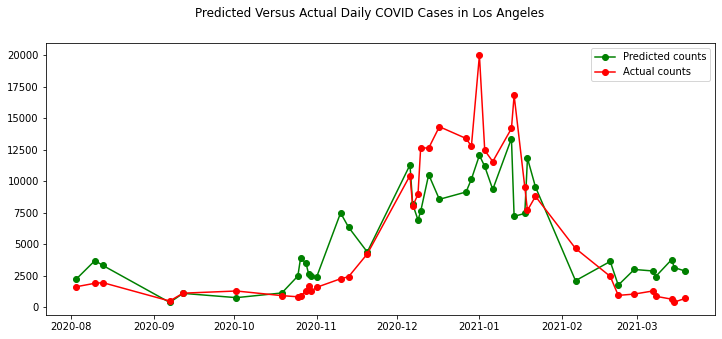

In [103]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['New_Cases']
fig = plt.figure(figsize = (12,5))
fig.suptitle('Predicted Versus Actual Daily COVID Cases in Los Angeles')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [100]:
#ERROR METRICS
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_counts, predicted_counts)
mse = mean_squared_error(actual_counts, predicted_counts)
rmse = np.sqrt(mse)
r2 = r2_score(actual_counts, predicted_counts)

print ("\n", "MAE:", mae, "\n", "MSE:", mse, "\n", "RMSE:", rmse, "\n", "R-squared:", r2)


 MAE: 2270.5065414119895 
 MSE: 9386230.043207424 
 RMSE: 3063.695488002589 
 R-squared: 0.700020723566017


In [101]:
#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y_train, X_train, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit()

#print the results
print(gen_poisson_gp2_results.summary())

         Current function value: 9.235114
         Iterations: 35
         Function evaluations: 47
         Gradient evaluations: 47
                    GeneralizedPoisson Regression Results                     
Dep. Variable:              New_Cases   No. Observations:                  201
Model:             GeneralizedPoisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            7
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                 0.01965
Time:                        00:30:36   Log-Likelihood:                -1856.3
converged:                      False   LL-Null:                       -1893.5
Covariance Type:            nonrobust   LLR p-value:                 1.897e-13
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     11.6831      0

C:\Users\charl\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [102]:
gen_poisson_gp1 = sm.GeneralizedPoisson(y_train, X_train, p=1)
gen_poisson_gp1_results = gen_poisson_gp1.fit()
print(gen_poisson_gp1_results.summary())

         Current function value: 9.365487
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 50
                    GeneralizedPoisson Regression Results                     
Dep. Variable:              New_Cases   No. Observations:                  201
Model:             GeneralizedPoisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            7
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                0.005807
Time:                        00:30:44   Log-Likelihood:                -1882.5
converged:                      False   LL-Null:                       -1893.5
Covariance Type:            nonrobust   LLR p-value:                  0.002549
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      8.7503      0

C:\Users\charl\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


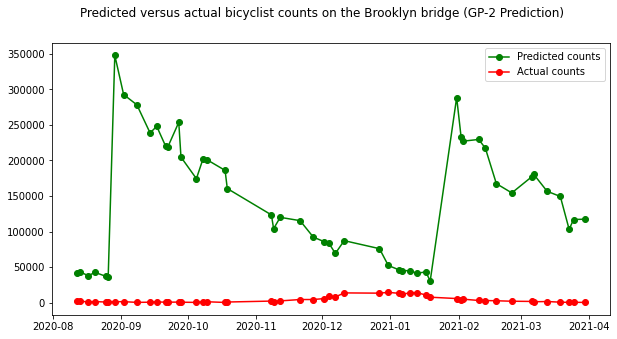

In [10]:
gen_poisson_gp2_predictions = gen_poisson_gp2_results.predict(X_test)

predicted_counts=gen_poisson_gp2_predictions
actual_counts = y_test['New_Cases']
fig = plt.figure(figsize = (10,5))
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge (GP-2 Prediction)')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

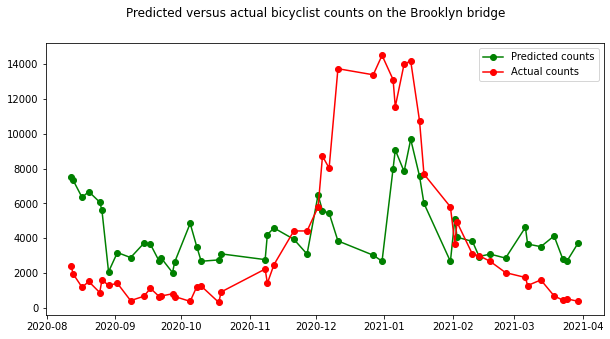

In [11]:
gen_poisson_gp1_predictions = gen_poisson_gp1_results.predict(X_test)

predicted_counts=gen_poisson_gp1_predictions
actual_counts = y_test['New_Cases']
fig = plt.figure(figsize = (10,5))
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

## Deaths

In [113]:
expr = 'New_Deaths ~ Relative_Humidity  + Average_Temperature + Average_Wind_Speed + Days_since_lockdown_lifted + Month + Day + Day_of_Week'
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             New_Deaths   No. Observations:                  201
Model:                            GLM   Df Residuals:                      193
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4815.2
Date:                Sun, 25 Apr 2021   Deviance:                       8525.0
Time:                        00:34:51   Pearson chi2:                 1.06e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [114]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                  mean   mean_se  mean_ci_lower  mean_ci_upper
2020-08-03   31.604025  0.986117      29.729183      33.597102
2020-08-10   46.254411  1.114199      44.121371      48.490573
2020-08-13   44.259525  0.977618      42.384314      46.217702
2020-09-07   19.320816  0.584164      18.209140      20.500360
2020-09-12   33.743041  0.815177      32.182559      35.379189
2020-10-02   19.971486  0.563686      18.896683      21.107420
2020-10-19   28.466864  0.729541      27.072306      29.933258
2020-10-25   35.795436  0.845694      34.175696      37.491941
2020-10-26   58.151950  1.578581      55.138854      61.329699
2020-10-28   60.408827  1.309698      57.895640      63.031109
2020-10-29   51.399697  1.139256      49.214602      53.681808
2020-10-30   46.418572  1.003346      44.493124      48.427344
2020-11-01   26.041953  0.721815      24.664962      27.495819
2020-11-10   59.714054  1.422627      56.989854      62.568476
2020-11-13   50.479397  1.069708      48.425751      52

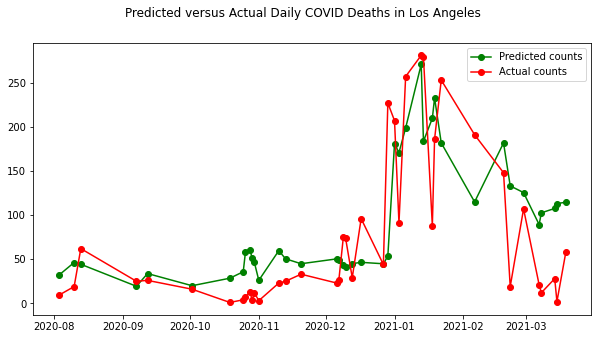

In [116]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['New_Deaths']
fig = plt.figure(figsize = (10,5))
fig.suptitle('Predicted versus Actual Daily COVID Deaths in Los Angeles')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [69]:
mae = mean_absolute_error(actual_counts, predicted_counts)
mse = mean_squared_error(actual_counts, predicted_counts)
rmse = np.sqrt(mse)
r2 = r2_score(actual_counts, predicted_counts)

print ("\n", "MAE:", mae, "\n", "MSE:", mse, "\n", "RMSE:", rmse, "\n", "R-squared:", r2)


 MAE: 43.368476094357014 
 MSE: 4152.2185908676165 
 RMSE: 64.4377109375218 
 R-squared: 0.503563385102896


In [117]:
#GP-1
gen_poisson_gp1 = sm.GeneralizedPoisson(y_train, X_train, p=1)
gen_poisson_gp1_results = gen_poisson_gp1.fit()
print(gen_poisson_gp1_results.summary())

Optimization terminated successfully.
         Current function value: 5.114829
         Iterations: 29
         Function evaluations: 37
         Gradient evaluations: 37
                    GeneralizedPoisson Regression Results                     
Dep. Variable:             New_Deaths   No. Observations:                  201
Model:             GeneralizedPoisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            7
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                 0.04451
Time:                        00:37:47   Log-Likelihood:                -1028.1
converged:                       True   LL-Null:                       -1076.0
Covariance Type:            nonrobust   LLR p-value:                 7.971e-18
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Interc

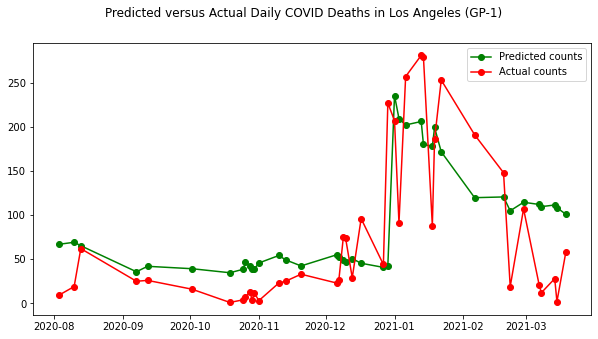

In [120]:
gen_poisson_gp1_predictions = gen_poisson_gp1_results.predict(X_test)

predicted_counts=gen_poisson_gp1_predictions
actual_counts = y_test['New_Deaths']
fig = plt.figure(figsize = (10,5))
fig.suptitle('Predicted versus Actual Daily COVID Deaths in Los Angeles (GP-1)')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [119]:
mae = mean_absolute_error(actual_counts, predicted_counts)
mse = mean_squared_error(actual_counts, predicted_counts)
rmse = np.sqrt(mse)
r2 = r2_score(actual_counts, predicted_counts)

print ("\n", "MAE:", mae, "\n", "MSE:", mse, "\n", "RMSE:", rmse, "\n", "R-squared:", r2)


 MAE: 49.049983723308685 
 MSE: 3811.625945772434 
 RMSE: 61.73836688617892 
 R-squared: 0.48675262987390977


In [74]:
#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y_train, X_train, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit()

#print the results
print(gen_poisson_gp2_results.summary())

Optimization terminated successfully.
         Current function value: 5.101526
         Iterations: 27
         Function evaluations: 36
         Gradient evaluations: 36
                    GeneralizedPoisson Regression Results                     
Dep. Variable:             New_Deaths   No. Observations:                  193
Model:             GeneralizedPoisson   Df Residuals:                      185
Method:                           MLE   Df Model:                            7
Date:                Sat, 24 Apr 2021   Pseudo R-squ.:                 0.04190
Time:                        22:18:31   Log-Likelihood:                -984.59
converged:                       True   LL-Null:                       -1027.7
Covariance Type:            nonrobust   LLR p-value:                 7.762e-16
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Interc

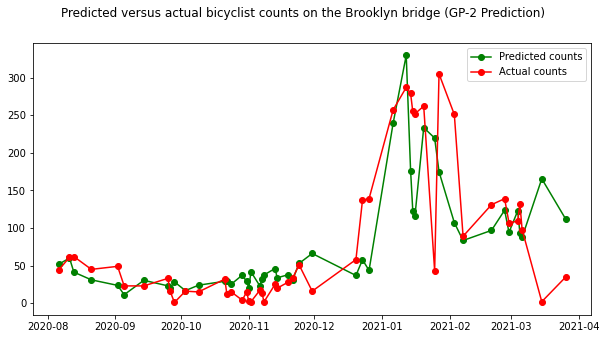

In [75]:
gen_poisson_gp2_predictions = gen_poisson_gp2_results.predict(X_test)

predicted_counts=gen_poisson_gp2_predictions
actual_counts = y_test['New_Deaths']
fig = plt.figure(figsize = (10,5))
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge (GP-2 Prediction)')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [76]:
mae = mean_absolute_error(actual_counts, predicted_counts)
mse = mean_squared_error(actual_counts, predicted_counts)
rmse = np.sqrt(mse)
r2 = r2_score(actual_counts, predicted_counts)

print ("\n", "MAE:", mae, "\n", "MSE:", mse, "\n", "RMSE:", rmse, "\n", "R-squared:", r2)


 MAE: 38.99750857299725 
 MSE: 3693.4200377630245 
 RMSE: 60.77351427853275 
 R-squared: 0.5584170484249276


In [7]:
final_time_data.to_csv("C:/Users/charl/Documents/STA378 Bicycle Code/Case Study 2 Data.csv")